In [2]:
import numpy as np
from numpy import pi,e,sqrt,log,cos,sin
from matplotlib import pyplot as plt
import sympy as sym
def vector_average(vecs,director):
    # vecs = [v1,v2,v3,...,vn]
    # director = unit vector
    cum=np.zeros(np.shape(director))
    # normalize just in case
    director=director/np.linalg.norm(director)
    for v in vecs:
        cum+= v*np.dot(v,director)
    return cum

def v_mat(vecs):
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  v *outer* v /norm(v)
    """
    return sum([np.outer(v,v)/np.linalg.norm(v) for v in vecs])

def v_mat_sym(vecs):
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  v *outer* v /norm(v)
    """
    return sum([np.outer(v,v)/sym.sqrt(np.dot(v,v)) for v in vecs])
def b_mat_sym(vecs,pols):
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  v *outer* v /norm(v)
    """
    return sum([s*np.outer(v,v)/sym.sqrt(np.dot(v,v)) for (v,s) in zip(vecs,pols)])
    
    
    
def b_mat(vecs,pols): 
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  polz*v *outer* v /norm(v)
    """
    return sum([s*np.outer(v,v)/np.linalg.norm(v) for (v,s) in zip(vecs,pols)])
    
def random_vecs(n,balanced=True):
    vs=[]
    ## Random set of n 3-vectors which are balanced
    for ii in range(0,n-1):
        vs.append(2*(np.random.rand(3)-0.5))
    if balanced:
        ## Last vector is -sum of all other vectors
        vs.append(-1*sum(vs)    )
    else:
        vs.append(2*(np.random.rand(3)-0.5))
    return vs

def run_random_test(n=4):
    vs=random_vecs(n,balanced=True)
    #director is independent vector
    director=2*(np.random.rand(3)-0.5)
    director=director/np.linalg.norm(director)

    avg=vector_average(vs,director)

    ##
    return np.dot(director,avg)/np.linalg.norm(avg)

def run_random_unit_test(n=4):
    vs=[]
    ## Random set of unit 3-vectors which are balanced
    for ii in range(0,n-1):
        v=np.random.rand(3)-0.5
        vs.append(v/np.linalg.norm(v))
    ## Last vector is -sum of all other vectors
    ## will not be normalized in general
    vs.append(-1*sum(vs)    )

    #director is independent vector
    director=2*(np.random.rand(3)-0.5)
    director=director/np.linalg.norm(director)

    avg=vector_average(vs,director)

    ##
    return np.dot(director,avg)/np.linalg.norm(avg)

In [5]:
from scipy.special import ellipk as K
from scipy.special import ellipe as E
mu0=1.25663706212e-6#N/A^2
def loop_primitive(r,z_d,diam=1,I=1):
    """
    Tests
    B(0,0) for 1A, 1m diameter: 0.01256637062 gauss
    B(0,1) for 1A, 1m diameter: 0.00444288294 gauss
    r,z_d are the radial and axial coordinate, given in units of the loop diameter!
    Using analytic formula from: https://tiggerntatie.github.io/emagnet/offaxis/iloopoffaxis.htm
    """
    mu0=1.25663706212e-6#N/A^2
    z=z_d*2 #simplifies the algebra to use radius as dimension
    r=r*2
    B0=1e4*I*mu0/diam ##[gauss] Field strength at center of loop
    
    Q=(1+r)**2 + z**2
    m=4*r/Q
    Bz=B0/(pi*sqrt(Q))*( E(m)*(1-r**2-z**2)/(Q-4*r)+K(m))
    ## Keep track of where r==0 to avoid div by 0
    r_reg=np.copy(r)
    reg_idx=np.where(r==0)
    r_reg[np.where(r==0)]=1
    Br=B0/(pi*sqrt(Q))*(z/r_reg)*( E(m)*(1+r**2+z**2)/(Q-4*r)-K(m))
    ## force B_r=0 on axis
    Br[reg_idx]=0
    return Br,Bz ## Gauss


def loop_tilt(r,z_d,diam=1,I=1,angle=0):
    """
    Tilt the loop by angle [rad] CCW sense
    """
    rotation=np.array([
        [cos(angle),sin(angle)],
        [-sin(angle),cos(angle)]
    ])
    ## Rotate the spatial coordinates
    r_rot,z_rot = np.einsum('ji, mni -> jmn',rotation, np.dstack([r,z_d]))
    ## Evaluate the magnetic field in the rotated coordinates
    Br_rot, Bz_rot = loop_primitive(r_rot,z_rot,diam=diam,I=I)
    ## Undo the rotation on the magnetic field
    Br,Bz = np.einsum('ji, mni -> jmn',np.linalg.inv(rotation), np.dstack([Br_rot,Bz_rot]))
    return Br,Bz

def gradient(Br,Bz,r,z):
    """
    Br,Bz in Gauss
    r,z in meters
    Return [[Brr, Brz],
            [Bzr, Bzz]] 
        in Gauss/meter
        Evaluated at the field minimum
    """
    mag=sqrt(Br**2+Bz**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))

    print(f"Field minimum @ r={r[min_idx]}, z={z[min_idx]}")
    dr,dz=r[0,1]-r[0,0],z[1,0]-z[0,0]
    Grad_Br=np.gradient(Br,dz,dr)
    Grad_Bz=np.gradient(Bz,dz,dr)
    Grad_B=np.array([[Grad_Br[1][min_idx],Grad_Br[0][min_idx]],
                [Grad_Bz[1][min_idx],Grad_Bz[0][min_idx]]]) ## Gauss/meter
    
    return Grad_B

def loop_on_axis(z_d,diam=1,I=1):
    r=diam/2
    z=z_d*diam
    return 1e4*mu0/(4*pi) *(2*pi*r**2*I)/(z**2+r**2)**(3/2)
def loop_test():
    z=np.linspace(-10,10,50)
    
    _,Bz=loop_primitive(np.array([0]),z,diam=1,I=1)
    
    Bz_=loop_on_axis(z,diam=1,I=1)
    err=2*(Bz-Bz_)/(Bz+Bz_)
    print("Testing analytic off axis formula against on-axis formula")
    print(f"Maximum relative error: {np.max(err)}")
    print(f"Mean relative error: {np.mean(err)}")
    if np.max(err) < 10**10:
        print("TEST PASSED")
        
loop_test()

Testing analytic off axis formula against on-axis formula
Maximum relative error: 1.8459101151082075e-14
Mean relative error: 1.906155831088675e-15
TEST PASSED


In [9]:
v1=np.array([1,0,0])
v2=np.array([-1,0,0])
director=np.array([0.5,0.5,0])
vector_average([v1,v2],director)

array([1.41421356, 0.        , 0.        ])

In [27]:
vs=[]
for angle in [0,2*pi/3,4*pi/3]:
    vs.append(np.array([cos(angle),sin(angle),0  ]))
director=np.array([0,1,0])
vector_average(vs,director)

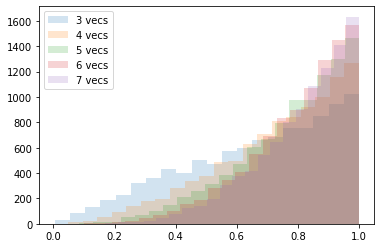

In [113]:
"""This experiment shows that the vector-weighted average
tends to point in the direction of the director, 
and *never* points away from it
"""
n_samples=10000
for n_vecs in range(3,8):
    result=np.zeros(n_samples)
    for i in range(n_samples):
        result[i]=run_random_test(n=n_vecs)

    plt.hist(result,bins=20,alpha=0.2,label=str(n_vecs)+" vecs")

plt.legend()
plt.show()

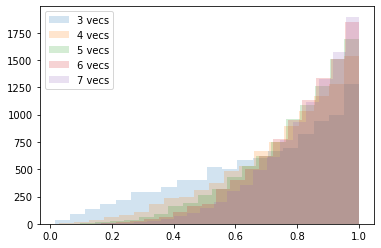

In [116]:
"""This experiment shows that the vector-weighted average
tends to point in the direction of the director, 
and *never* points away from it
"""
n_samples=10000
for n_vecs in range(3,8):
    result=np.zeros(n_samples)
    for i in range(n_samples):
        result[i]=run_random_unit_test(n=n_vecs)

    plt.hist(result,bins=20,alpha=0.2,label=str(n_vecs)+" vecs")

plt.legend()
plt.show()

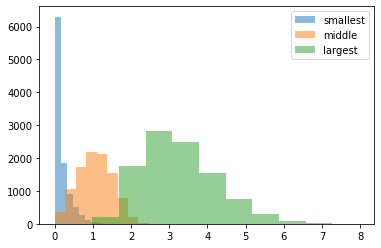

In [162]:
"""
The matrix formed by v *outer* \hat{v} has nonnegative eigenvalues
I dont know how to prove it rigorously
Intuitively, this is because v^2 > 0
"""

n_samples=10000
result=np.zeros((n_samples,3))
for n in range(n_samples):
    vs=random_vecs(4,balanced=True)
    eigs=np.linalg.eigvals(v_mat(vs))
    eigs.sort()
    result[n,:]=eigs
plt.hist(result[:,0],label="smallest",alpha=0.5)
plt.hist(result[:,1],label="middle",alpha=0.5)
plt.hist(result[:,2],label="largest",alpha=0.5)
plt.legend()
plt.show()

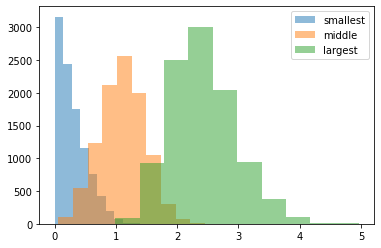

In [163]:
"""
The matrix formed by v *outer* \hat{v} has nonnegative eigenvalues
I dont know how to prove it rigorously
Intuitively, this is because v^2 > 0
If the set of vectors is not balanced, the smallest eigenvalue
tends to be bigger than in the balanced case
why?
"""

n_samples=10000
result=np.zeros((n_samples,3))
for n in range(n_samples):
    vs=random_vecs(4,balanced=False)
    eigs=np.linalg.eigvals(v_mat(vs))
    eigs.sort()
    result[n,:]=eigs
plt.hist(result[:,0],label="smallest",alpha=0.5)
plt.hist(result[:,1],label="middle",alpha=0.5)
plt.hist(result[:,2],label="largest",alpha=0.5)
plt.legend()
plt.show()

In [71]:
"""
Pure tetrahedron

unpolarized matrix:
All 3 eigenvalues are exactly 4/3
no preferred eigenvectors

polarized matrix:
xy-plane eigenvalues are -2x z-axis eigenvalue
"""

#th=109.47122*pi/180

th=sym.pi-sym.acos(sym.Rational(1,3))

rot=np.array([
    [sym.cos(2*sym.pi/3),sym.sin(2*sym.pi/3),0],
    [-sym.sin(2*sym.pi/3),sym.cos(2*sym.pi/3),0],
    [0,0,1]
])


v1=np.array([0,0,1])
v2=np.array([0,sym.sin(th),sym.cos(th)])
v3=np.matmul(rot,v2)
v4=np.matmul(rot,v3)
pols=[1,-1,-1,-1]
vs=[v1,v2,v3,v4]
print(vs)
mat=v_mat_sym(vs)
print(mat)

pol_mat = b_mat_sym(vs,pols)
print(pol_mat)

[array([0, 0, 1]), array([0, 2*sqrt(2)/3, -1/3], dtype=object), array([sqrt(6)/3, -sqrt(2)/3, -1/3], dtype=object), array([-sqrt(6)/3, -sqrt(2)/3, -1/3], dtype=object)]
[[4/3 0 0]
 [0 4/3 0]
 [0 0 4/3]]
[[-4/3 0 0]
 [0 -4/3 0]
 [0 0 2/3]]


In [25]:
"""
Cubic MOT config
"""

v1=np.array([0,0,1])
v2=np.array([0,0,-1])
v3=np.array([0,1,0])
v4=np.array([0,-1,0])
v5=np.array([1,0,0])
v6=np.array([-1,0,0])
vs=[v1,v2,v3,v4,v5,v6]
pols=[1,1,-1,-1,-1,-1]

mat=v_mat(vs)
print(mat)
print(np.linalg.eig(mat))
pol_mat = b_mat(vs,pols)
print(pol_mat)
print(np.linalg.eig(pol_mat))

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]
(array([2., 2., 2.]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))
[0 0 1] 1
[ 0  0 -1] 1
[0 1 0] -1
[ 0 -1  0] -1
[1 0 0] -1
[-1  0  0] -1
[[-2.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  2.]]
(array([-2., -2.,  2.]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))


In [7]:
"""
Pure Octahedron
"""

v1=np.array([1,1,1])
v2=np.array([1,1,-1])
v3=np.array([1,-1,1])
v4=np.array([1,-1,-1])
v5=np.array([-1,1,1])
v6=np.array([-1,1,-1])
v7=np.array([-1,-1,1])
v8=np.array([-1,-1,-1])
vs=[v1,v2,v3,v4,v5,v6,v7,v8]
pols=[1,-1,-1,-1,-1,1]

mat=v_mat(vs)
print(mat)
print(np.linalg.eig(mat))
pol_mat = b_mat(vs,pols)
print(pol_mat)
print(np.linalg.eig(pol_mat))

[[4.61880215 0.         0.        ]
 [0.         4.61880215 0.        ]
 [0.         0.         4.61880215]]
(array([4.61880215, 4.61880215, 4.61880215]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))
[[-1.15470054e+00  1.15470054e+00  2.30940108e+00]
 [ 1.15470054e+00 -1.15470054e+00  2.22044605e-16]
 [ 2.30940108e+00  2.22044605e-16 -1.15470054e+00]]
(array([-3.73668944,  1.42728836, -1.15470054]), array([[-7.07106781e-01,  7.07106781e-01,  8.59975057e-17],
       [ 3.16227766e-01,  3.16227766e-01, -8.94427191e-01],
       [ 6.32455532e-01,  6.32455532e-01,  4.47213595e-01]]))


In [3]:
"""
Ideal gMOT at 45-deg

2 degenerate eigenvalues in the xy plane
largest eigenvalue along z-axis
"""
rot=np.array([
    [sym.cos(2*sym.pi/3),sym.sin(2*sym.pi/3),0],
    [-sym.sin(2*sym.pi/3),sym.cos(2*sym.pi/3),0],
    [0,0,1]
])

eff=sym.Rational(1,3)
v1=np.array([0,0,-1])
v2=eff*sym.sqrt(2)*np.array([1/sym.sqrt(2),0,1/sym.sqrt(2)])
v3=np.matmul(rot,v2)
v4=np.matmul(rot,v3)
vs=[v1,v2,v3,v4]
print(vs)
pols=[1,-1,-1,-1]
mat=v_mat_sym(vs)
print(mat)
pol_mat = b_mat_sym(vs,pols)
print(pol_mat)


b,x,y,z=sym.symbols("b x y z")
B=b*np.array([x,y,-2*z])
print(np.matmul(pol_mat,B))

[array([ 0,  0, -1]), array([1/3, 0, 1/3], dtype=object), array([-1/6, -sqrt(3)/6, 1/3], dtype=object), array([-1/6, sqrt(3)/6, 1/3], dtype=object)]
[[sqrt(2)/4 0 0]
 [0 sqrt(2)/4 0]
 [0 0 sqrt(2)/2 + 1]]
[[-sqrt(2)/4 0 0]
 [0 -sqrt(2)/4 0]
 [0 0 1 - sqrt(2)/2]]
[-sqrt(2)*b*x/4 -sqrt(2)*b*y/4 -2*b*z*(1 - sqrt(2)/2)]


In [133]:
"""
Unbalanced, symmetric gMOT at 45-deg

2 degenerate eigenvalues in the xy plane
largest eigenvalue along z-axis
"""
rot=np.array([
    [sym.cos(2*sym.pi/3),sym.sin(2*sym.pi/3),0],
    [-sym.sin(2*sym.pi/3),sym.cos(2*sym.pi/3),0],
    [0,0,1]
])

q=sym.Symbol("q")
eff=q
v1=np.array([0,0,-1])
v2=eff*sym.sqrt(2)*np.array([1/sym.sqrt(2),0,1/sym.sqrt(2)])
v3=np.matmul(rot,v2)
v4=np.matmul(rot,v3)
vs=[v1,v2,v3,v4]
print(vs)
print("")
pols=[1,-1,-1,-1]
mat=v_mat_sym(vs)
print(sym.simplify(mat))
print("")
pol_mat = b_mat_sym(vs,pols)
print(sym.simplify(pol_mat))
print("")


b,x,y,z=sym.symbols("b x y z")
B=b*np.array([x,y,-2*z])
print(np.matmul(pol_mat,B))
print("")
tot=sum([sym.sqrt(np.dot(v,v)) for v in vs ] )
print("beta_tot/beta = {}".format(tot))

[array([ 0,  0, -1]), array([q, 0, q], dtype=object), array([-q/2, -sqrt(3)*q/2, q], dtype=object), array([-q/2, sqrt(3)*q/2, q], dtype=object)]

[[3*sqrt(2)*q**2/(4*sqrt(q**2)), 0, 0], [0, 3*sqrt(2)*q**2/(4*sqrt(q**2)), 0], [0, 0, 3*sqrt(2)*q**2/(2*sqrt(q**2)) + 1]]

[[-3*sqrt(2)*q**2/(4*sqrt(q**2)), 0, 0], [0, -3*sqrt(2)*q**2/(4*sqrt(q**2)), 0], [0, 0, -3*sqrt(2)*q**2/(2*sqrt(q**2)) + 1]]

[-3*sqrt(2)*b*q**2*x/(4*sqrt(q**2)) -3*sqrt(2)*b*q**2*y/(4*sqrt(q**2))
 -2*b*z*(-3*sqrt(2)*q**2/(2*sqrt(q**2)) + 1)]

beta_tot/beta = 3*sqrt(2)*sqrt(q**2) + 1


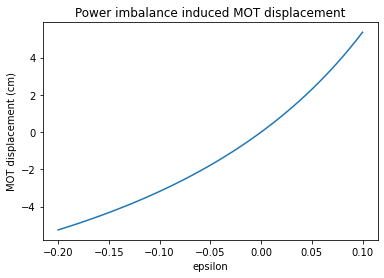

In [134]:
def zeq(epsilon):
    mu = 0.006
    b= 10
    delta= 2
    K= 1/(1+16+2.3*(1+sqrt(2) *(1+epsilon)))
    return 1/(8*delta*K) * 1/(mu*b) * epsilon / (2-sqrt(2)*(1+epsilon))
eps = np.linspace(-0.2,0.1,50)
zs=zeq(eps)
plt.plot(eps,zs)
plt.xlabel("epsilon")
plt.ylabel("MOT displacement (cm)")
plt.title("Power imbalance induced MOT displacement")
plt.show()

In [177]:
zeq(0.1)

5.362979598812547

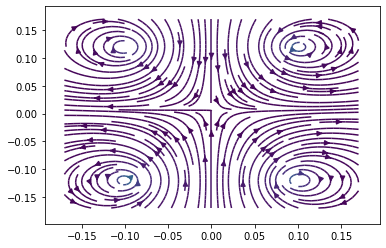

In [135]:
## Anti-helmholtz configuration

## Physical dimensions of Lithium MOT coil setup
## For testing gMOT in old minig chamber
d=0.2 #[m]
n_turns=8*8+1
Itop=30 #[A]
Ibottom=25 #[A]
z_spacing=0.24 #[m]

r,z=np.meshgrid(np.linspace(-0.17,0.17,100),np.linspace(-0.17,0.17,100))
tilt_rad=0*pi/180
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=tilt_rad)


Br_tot,Bz_tot=Br+Br2,Bz+Bz2
mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
#plt.quiver(r,z,Br+Br2,Bz+Bz2)
plt.streamplot(r,z,Br_tot,Bz_tot,density=1.5,color=mag)
plt.show()

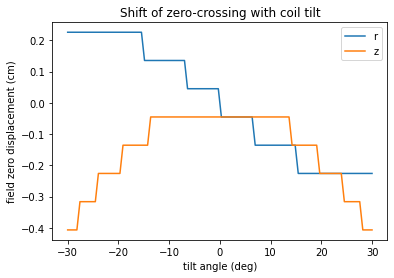

In [137]:
# How does the field zero position depend on a tilt?
n_samples=100
r0,z0=[],[]
I=30
tilts=np.linspace(-30,30,n_samples)
r,z=np.meshgrid(np.linspace(-0.09,0.09,200),np.linspace(-0.09,0.09,200))
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*I,angle=0)
for tilt in tilts:
    tilt_rad=tilt*pi/180
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*I,angle=tilt_rad)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(tilts,r0*100,label="r")
plt.plot(tilts,z0*100,label="z")
plt.xlabel("tilt angle (deg)")
plt.ylabel("field zero displacement (cm)")
plt.title("Shift of zero-crossing with coil tilt")
plt.legend()
plt.show()


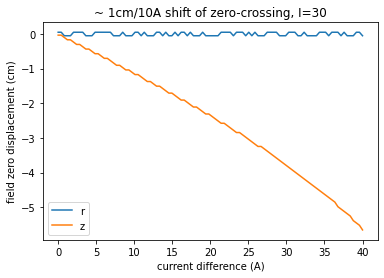

In [138]:
## How does the field zero depend on a current difference?
n_samples=100
r0,z0,b0=[],[],[]
dIs=np.linspace(0,40,n_samples)
r,z=np.meshgrid(np.linspace(-0.05,0.05,100),np.linspace(-0.1,0.1,300))
I=30
for dI in dIs:
    Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*(I-dI/2),angle=0)
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*(I+dI/2),angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
    b0.append(mag[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(dIs,r0*100,label="r")
plt.plot(dIs,z0*100,label="z")
plt.xlabel("current difference (A)")
plt.ylabel("field zero displacement (cm)")
plt.title("~ 1cm/10A shift of zero-crossing, I={}".format(I))
plt.legend()
plt.show()


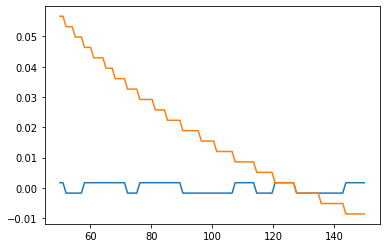

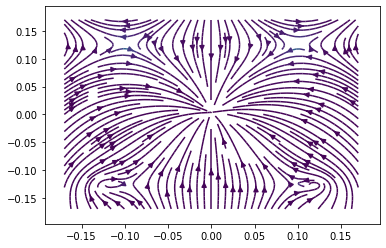

In [141]:
## Anti-helmholtz configuration

## Physical dimensions of Lithium MOT coil setup
## For testing gMOT in old minig chamber
d=0.2 #[m]
n_turns=8*8+1
Itop=60 #[A]
Ibottom=20 #[A]
z_spacing=0.25 #[m]

## tetrahedral MOT polz dependent structure matrix
eps=0.1
beta=2.3
beta_tot=(1+sqrt(2)*(1+eps))*beta
Delta_Gamma=2
mu_Gamma=0.006


KK=1/(1+beta_tot+4*Delta_Gamma**2)
C=8*Delta_Gamma*KK**2

Prr,Pzz=beta*(-sqrt(2)/4)*(1+eps),beta*(1-sqrt(2)/2*(1+eps) )
B0=-KK *beta*eps/(C*mu_Gamma*Pzz)

r,z=np.meshgrid(np.linspace(-0.17,0.17,100),np.linspace(-0.17,0.17,100))

## Try a bunch of different currents to tune in the zero crossing
n_samples=100
r0,z0,a0=[],[],[]
Is=np.linspace(50,150,n_samples)
for Itop in Is:
    Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=0)
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2+B0
    ar=-C*mu_Gamma*Prr*Br_tot
    az=-C*mu_Gamma*Pzz*Bz_tot
    mag=sqrt(ar**2+az**2)
    
    
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
    a0.append(mag[min_idx])
    #a_tot=a_B+a_net
plt.plot(Is,r0)
plt.plot(Is,z0)
plt.show()


Itop=120
Ibottom=20
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=0)
Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
Br_tot,Bz_tot=Br+Br2,Bz+Bz2+B0
ar=-C*mu_Gamma*Prr*Br_tot
az=-C*mu_Gamma*Pzz*Bz_tot
mag=sqrt(ar**2+az**2)
plt.streamplot(r,z,ar,az,density=1.5,color=mag)
plt.show()

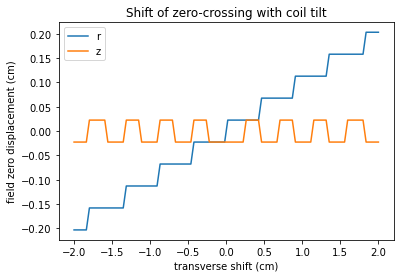

In [11]:
# How does the field zero position depend on a transverse coil shift?
n_samples=100
r0,z0=[],[]
shifts=np.linspace(-0.02,0.02,n_samples)
r,z=np.meshgrid(np.linspace(-0.09,0.09,400),np.linspace(-0.09,0.09,400))
I=40 #[A]
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*I,angle=0)
for shift in shifts:
    Br2,Bz2=loop_tilt(r/d-shift,(z-z_spacing/2)/d,diam=d,I=-n_turns*I,angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(shifts*100,r0*100,label="r")
plt.plot(shifts*100,z0*100,label="z")
plt.xlabel("transverse shift (cm)")
plt.ylabel("field zero displacement (cm)")
plt.title("Shift of zero-crossing with coil tilt")
plt.legend()
plt.show()


Coil diameter: 7.6 cm
wire length: 1.1e+01 m 
 resistance: 0.095 Ohm 
 Voltage: 0.62 V 
 Power: 4.0 W
Using 48 turns, make a 6x8 grid. z=13.0 mm, r=9.7 mm
Field minimum @ r=0.0, z=-0.009855
Gradient [Gauss/cm]:
 [[-4.88498170e+00  0.00000000e+00]
 [-1.31581988e-13  9.76997080e+00]]


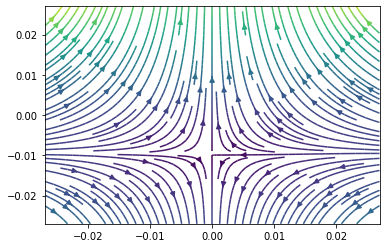

In [14]:
""" Designing a MOT coil geometry 
    Target 5-10 Gauss/cm gradient
    <~3A current
    <5V drop across each coil
"""

n_turns=48
Itop=6.5#[A]
Ibottom=3 #[A]
z_spacing=0.074 #[m]
d=2*0.038 #[m], to cancel 3rd order field variations
print(f"Coil diameter: {d*100:3.3} cm")


rad=d/2

wire_length=pi*d*n_turns
resistivity_14awg = 8.282e-3 ##ohm/meter
d_14awg=1.62 ## [mm]

resistance=wire_length*resistivity_14awg
print(f"wire length: {wire_length:0.2} m \n resistance: {resistance:0.2} Ohm \n Voltage: {Itop*resistance:0.2} V \n Power: {Itop**2*resistance:0.2} W")
print(f"Using 48 turns, make a 6x8 grid. z={8*d_14awg:2.3} mm, r={6*d_14awg:0.2} mm")



r,z=np.meshgrid(np.linspace(-0.027,0.027,401),np.linspace(-0.027,0.027,401))

Br,Bz  =loop_primitive(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom))
Br2,Bz2=loop_primitive(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop))
Br_tot,Bz_tot=Br+Br2,Bz+Bz2
mag=sqrt(Br_tot**2+Bz_tot**2)

Grad_B = gradient(Br_tot,Bz_tot,r,z)
print(f"Gradient [Gauss/cm]:\n {Grad_B/100}")


plt.streamplot(r,z,Br_tot,Bz_tot,density=1.5,color=mag)
plt.xlim(np.min(r),np.max(r))
plt.ylim(np.min(z),np.max(z))
plt.show()

In [ ]:

op